In [2]:
import time 
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms.optimizers import SLSQP, COBYLA, SciPyOptimizer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

def get_qubit_op_BeH2(angle, d = 1.33):
    # Define the molecular structure of H2O
    # Real O-H bond length in angstroms
    

    # Define the coordinates
    molecule = MoleculeInfo(
        symbols=["H", "Be", "H"],
        coords=([d, 0, 0.0],  # Hydrogen
                [0,0,0],  # Oxygen at origin
                [d*np.cos(angle), d*np.sin(angle), 0.0]),
        multiplicity=1,  # 2 * spin + 1; singlet state
        charge=0,
    ) #0.96
    driver = PySCFDriver.from_molecule(molecule,basis='sto-6g')

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [8]:
fr = 175
to = 185
angles = np.linspace(fr*np.pi/180, to*np.pi/180, 15)
distances = np.linspace(1.3, 1.4, 10)
optimizer = COBYLA(maxiter=3)
noiseless_estimator = Estimator(approximation=True)

# Make data.
X = [np.linspace(1.20, 1.40, 50)] # distance
xlen = len(X)
THETA = np.linspace(fr*np.pi/180, to*np.pi/180, 50) # angle in degrees
theta_len = len(THETA)

vqe_energies = np.empty(shape=(xlen,theta_len))

for (i, x) in enumerate(X):
    for (j, theta) in enumerate(THETA):
        tim = time.time()
        # print(x, theta)
        (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_BeH2(theta, x)

        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
        ansatz = UCCSD(
            num_spatial_orbitals, num_particles, mapper, initial_state=init_state
        )
        
        vqe = VQE(
            noiseless_estimator,
            ansatz,
            optimizer,
            initial_point=[0] * ansatz.num_parameters,
        )
        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        vqe_energies[i][j] = vqe_result
        print(f"Interatomic distance: {x}A, Angle: {np.round(theta * 180/np.pi, 2)} VQE Energy: {vqe_result:.5f}, Time:{(time.time() - tim):.2f}s")

np.savetxt('data.txt',vqe_energies)
np.savetxt('dataX.txt',X)
np.savetxt('dataTHETA.txt',THETA)


Interatomic distance: 1.3959183673469386A, Angle: 175.0 VQE Energy: -15.71648, Time:5.83s
Interatomic distance: 1.3959183673469386A, Angle: 175.2 VQE Energy: -15.71650, Time:5.89s
Interatomic distance: 1.3959183673469386A, Angle: 175.41 VQE Energy: -15.71652, Time:5.73s
Interatomic distance: 1.3959183673469386A, Angle: 175.61 VQE Energy: -15.71654, Time:5.70s
Interatomic distance: 1.3959183673469386A, Angle: 175.82 VQE Energy: -15.71655, Time:5.71s
Interatomic distance: 1.3959183673469386A, Angle: 176.02 VQE Energy: -15.71657, Time:5.50s
Interatomic distance: 1.3959183673469386A, Angle: 176.22 VQE Energy: -15.71658, Time:6.00s
Interatomic distance: 1.3959183673469386A, Angle: 176.43 VQE Energy: -15.71660, Time:6.40s
Interatomic distance: 1.3959183673469386A, Angle: 176.63 VQE Energy: -15.71661, Time:6.22s
Interatomic distance: 1.3959183673469386A, Angle: 176.84 VQE Energy: -15.71662, Time:5.69s
Interatomic distance: 1.3959183673469386A, Angle: 177.04 VQE Energy: -15.71663, Time:5.79s
I

In [13]:
# Make data.
X = np.linspace(1.20, 1.40, 50) # distance
xlen = len(X)
THETA = np.linspace(fr*np.pi/180, to*np.pi/180, 50) # angle in degrees
theta_len = len(THETA)
np.savetxt('dataX.txt',X)
np.savetxt('dataTHETA.txt',THETA)

min_energy = 100
min_theta = 1000
min_x = 100000

file1 = open('data.txt', 'r')

vqe_energies = np.empty(shape=(xlen,theta_len))

for i in range(50):
    for j in range(50):
        vqe_energies[i][j] = file1.readline()

for i in range(50):
    for j in range(50):
        if vqe_energies[i][j] < min_energy:
            min_energy = vqe_energies[i][j]
            min_theta = THETA[j]
            min_x = X[i]

print(f"VQE Minimum distance: {min_x}A Minimum angle: {min_theta} ({np.round(min_theta * 180/np.pi, 2)} degrees) Energy:{min_energy}")


VQE Minimum distance: 1.2857142857142856A Minimum angle: 3.139811705373472 (179.9 degrees) Energy:-15.72602


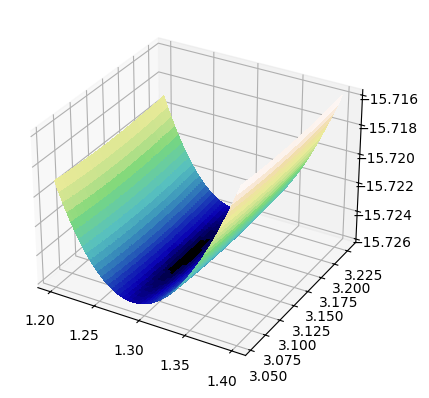

In [11]:
X = np.linspace(1.20, 1.40, 50) # distance
xlen = len(X)
THETA = np.linspace(fr*np.pi/180, to*np.pi/180, 50) # angle in degrees
X, THETA = np.meshgrid(X, THETA)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 90)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(vqe_energies.T, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X, THETA, vqe_energies.T, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()